In [29]:
from osa_pinn import osa_pinn_sdof
from sdof_oscillators import sdof_solution, generate_excitation

import numpy as np
import torch

import time as clock_time
import scipy

import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
def draw_sobol(n,ub):
    """ draws n integers with a maximum ub from a Sobol sequence """
    Sobol = scipy.stats.qmc.Sobol(d=1, seed=43810)
    sequence = Sobol.integers(ub, u_bounds=None, n=n)[:,0]
    return sequence

In [4]:
checkpoint = torch.load('checkpoints/sdof_free_osa.pth')

sdof_config = checkpoint['sdof_config']
pinn_config = checkpoint['pinn_config']

osa_model = osa_pinn_sdof(
    n_input = pinn_config['n_input'],
    n_output = pinn_config['n_output'],
    n_hidden = pinn_config['n_hidden'],
    n_layers = pinn_config['n_layers']
    )

osa_model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

## Check prediction against same vibration type

Test point 1 
Error: 7.4673e-06 -------- Compute Time: 2.3985e-04s
In time? True
Test point 2 
Error: -6.1933e-06 -------- Compute Time: 2.5797e-04s
In time? True
Test point 3 
Error: 1.6039e-05 -------- Compute Time: 5.8889e-05s
In time? True
Test point 4 
Error: 5.3224e-05 -------- Compute Time: 5.9366e-05s
In time? True
Test point 5 
Error: -2.9502e-05 -------- Compute Time: 5.2929e-05s
In time? True
Test point 6 
Error: -1.7859e-05 -------- Compute Time: 5.1975e-05s
In time? True
Test point 7 
Error: 1.7665e-05 -------- Compute Time: 4.6968e-05s
In time? True
Test point 8 
Error: 4.0673e-05 -------- Compute Time: 4.8161e-05s
In time? True
Test point 9 
Error: 2.9815e-05 -------- Compute Time: 4.8161e-05s
In time? True
Test point 10 
Error: -6.1337e-06 -------- Compute Time: 4.8161e-05s
In time? True
Test point 11 
Error: 2.9913e-05 -------- Compute Time: 4.7922e-05s
In time? True
Test point 12 
Error: 2.6216e-05 -------- Compute Time: 4.8876e-05s
In time? True
Test point 13 
Error:

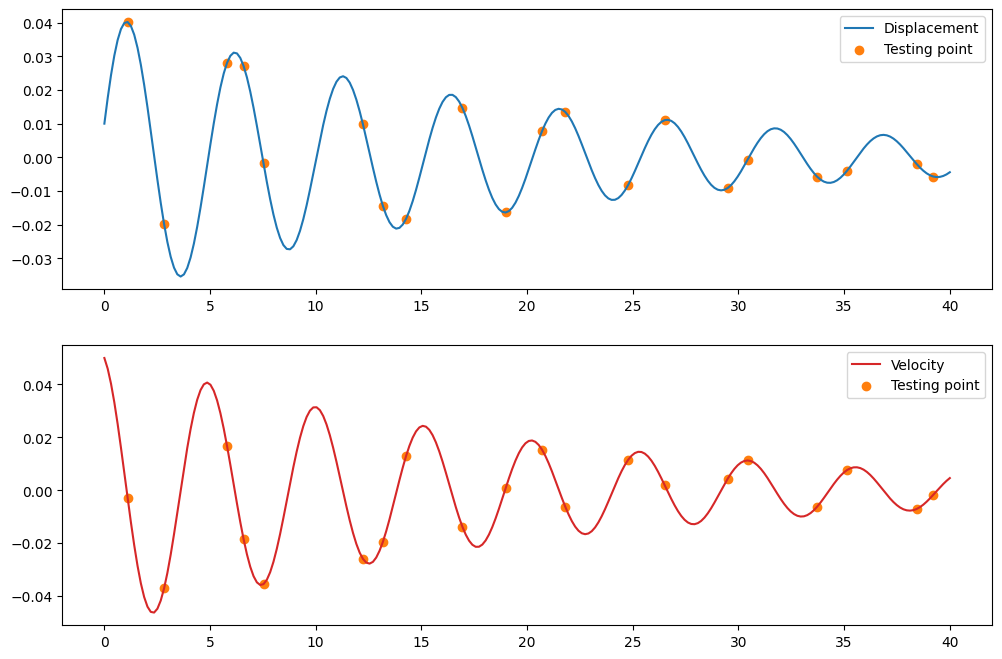

In [32]:
m = sdof_config['params']['m']
c = sdof_config['params']['c']
k = sdof_config['params']['k']
k_tild = k/m
c_tild = c/m

time = sdof_config['time_']
nt = time.shape[0]

xx, vv = sdof_solution(time, **sdof_config)

t_forw = (time[1]-time[0])

n_sel = 20
# sel_ids = np.random.randint(nt, size=n_sel)
sel_ids = draw_sobol(n_sel, nt)

fig, axs = plt.subplots(2,1,figsize=(12,8))

axs[0].plot(time, xx, color="tab:blue", label="Displacement")
axs[0].scatter(time[sel_ids], xx[sel_ids], color="tab:orange", label="Testing point")
axs[0].legend()

axs[1].plot(time, vv, color="tab:red", label="Velocity")
axs[1].scatter(time[sel_ids], vv[sel_ids], color="tab:orange", label="Testing point")
axs[1].legend()

err = [0] * n_sel
cp_times = [0] * n_sel

alpha_x = pinn_config['alphas']["x"]
alpha_v = pinn_config['alphas']["v"]
alpha_t = pinn_config['alphas']["t"]

for i, sel_ in enumerate(sel_ids):

    x_true = xx[sel_+1]

    st = clock_time.time()

    x_pred = osa_model.forward(xx[sel_]/alpha_x, vv[sel_]/alpha_v, t_forw/alpha_t)[0,0] * alpha_x

    et = clock_time.time()

    err[i] = x_pred - x_true
    cp_times[i] = et - st

    in_time = cp_times[i] < t_forw

    print("Test point %d \nError: %.4e -------- Compute Time: %.4es\nIn time? %r\n" % (i+1,err[i],cp_times[i],in_time))